# **CHILD AND INFANCT MORTALITY ANALYSIS**

## **IMPORTING MODULES**

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

## **READING FILES**

In [30]:
files = {
    "youth_mortality": "dataset/1_youth-mortality-rate.csv",
    "infant_deaths": "dataset/2_number-of-infant-deaths-unwpp.csv",
    "child_mortality_income": "dataset/3_child-mortality-by-income-level-of-country.csv",
    "causes_of_death": "dataset/4_Distribution_of_Causes_of_Death_among_Children_Aged_less_than_5_years.csv",
    "maternal_deaths": "dataset/5_number-of-maternal-deaths-by-region.csv",
    "births_by_staff": "dataset/6_births-attended-by-health-staff-sdgs.csv",
    "vaccination_coverage": "dataset/7_global-vaccination-coverage.csv",
    "health_insurance": "dataset/8_health-protection-coverage.csv"
}

data = {name: pd.read_csv(path) for name, path in files.items()}

## **DATA WRANGLING**

In [31]:
# Drop completely empty columns in all files
for name, df in data.items():
    data[name] = df.dropna(axis=1, how='all')

# Remove unnecessary columns in causes_of_death
if "causes_of_death" in data:
    data["causes_of_death"].drop(columns=["DateModified", "Language"], inplace=True, errors="ignore")

# Drop rows with missing values and reset index
for name, df in data.items():
    data[name] = df.dropna().reset_index(drop=True)

# Standardize column renaming
column_renames = {
    "youth_mortality": {"Entity": "Country", "Under-fifteen mortality rate": "Youth Mortality Rate"},
    "infant_deaths": {"Entity": "Country", "Deaths - Sex: all - Age: 0 - Variant: estimates": "Infant Deaths"},
    "child_mortality_income": {"Entity": "Country", "Observation value": "Under-five Mortality Rate"},
    "maternal_deaths": {"Entity": "Country", "Estimated maternal deaths": "Maternal Deaths"},
    "births_by_staff": {"Entity": "Country", "Births attended by skilled health staff (% of total)": "Births by Skilled Staff"},
    "health_insurance": {"Entity": "Country", "Share of population covered by health insurance (ILO (2014))": "Health Insurance Coverage"}
}

for name, renames in column_renames.items():
    if name in data:
        data[name].rename(columns=renames, inplace=True)

Available columns in 'causes_of_death': Index(['IndicatorCode', 'Indicator', 'ValueType', 'ParentLocationCode',
       'ParentLocation', 'Location type', 'SpatialDimValueCode', 'Location',
       'Period type', 'Period', 'IsLatestYear', 'Dim1 type', 'Dim1',
       'Dim1ValueCode', 'Dim2 type', 'Dim2', 'Dim2ValueCode',
       'FactValueNumeric', 'Value'],
      dtype='object')
Adjusting column names...
Critical columns missing in 'causes_of_death'


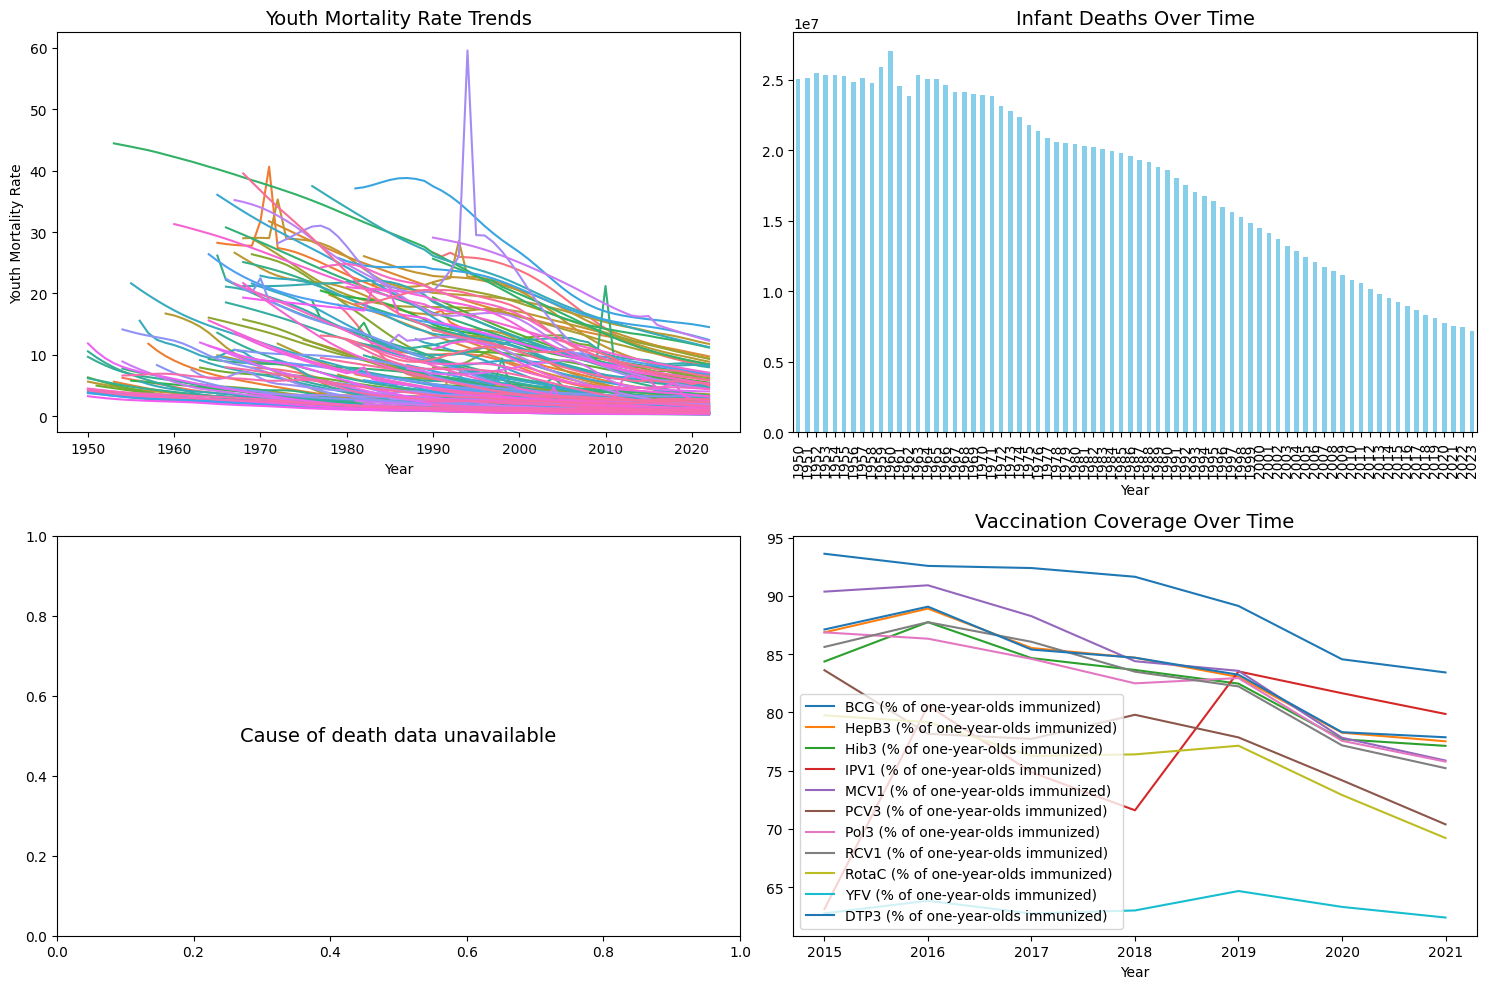

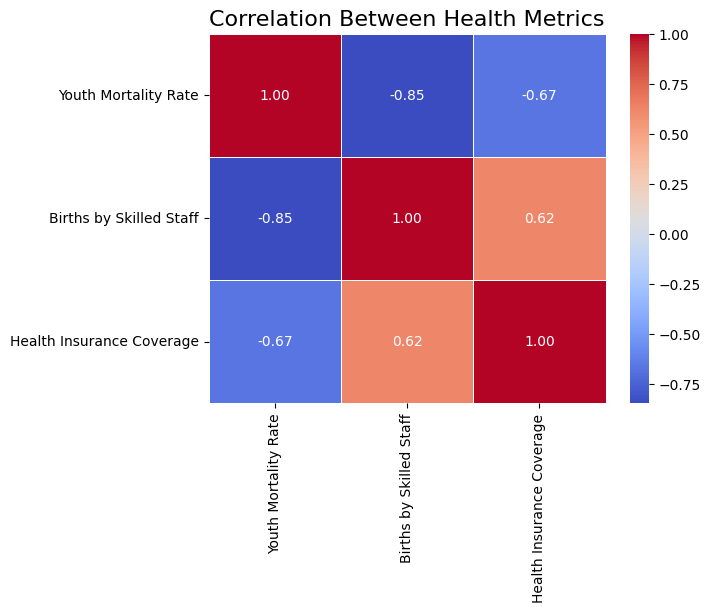

Mean Absolute Error: 1.67
R² Score: 0.60


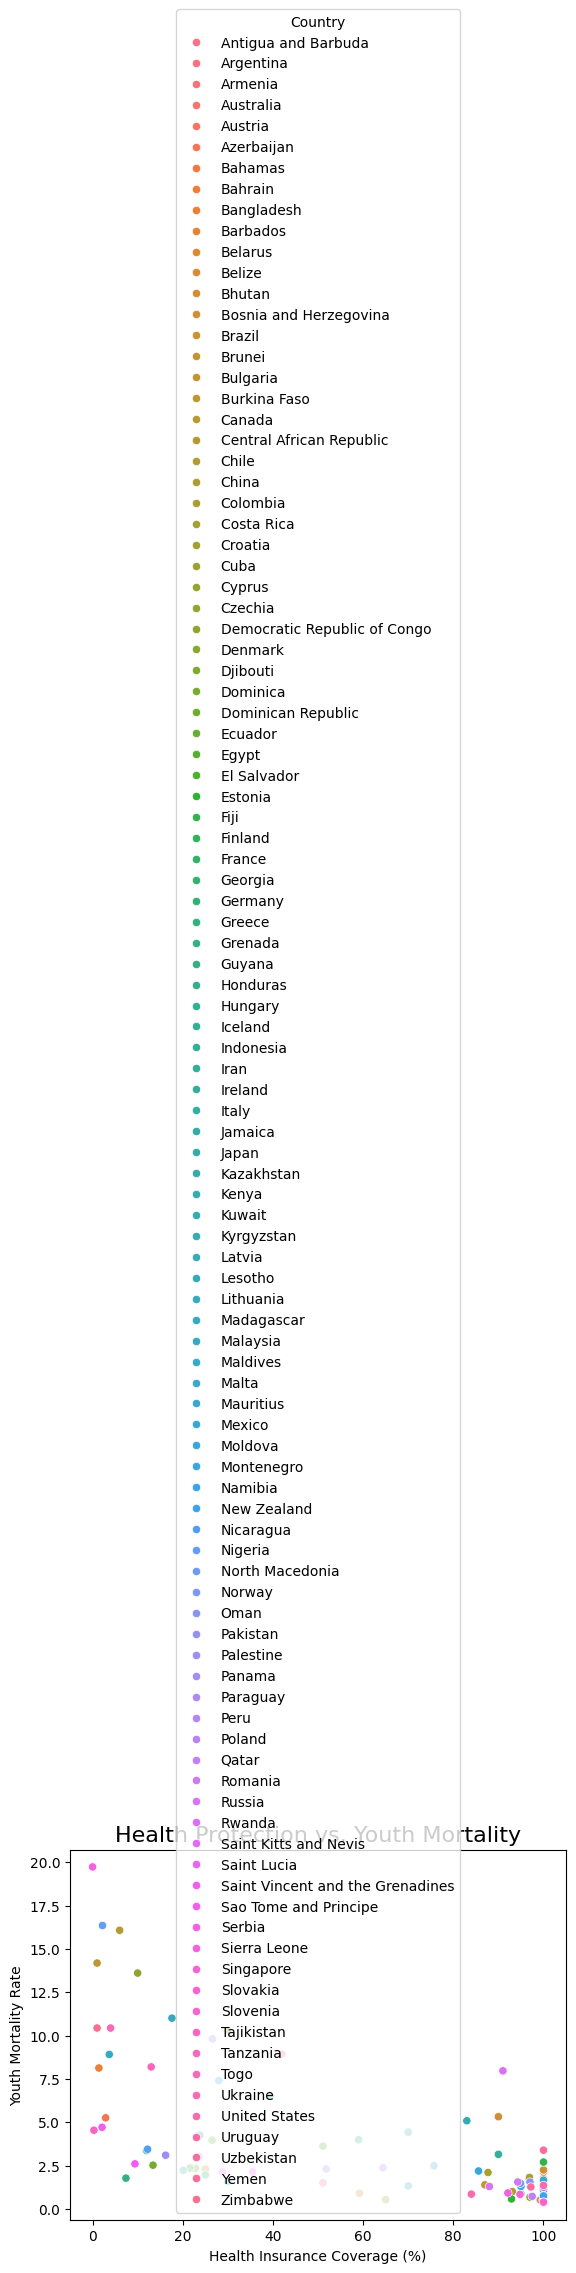

In [32]:
# #### **Exploratory Data Analysis**

# Create a figure with a 2x2 layout
fig, axes = plt.subplots(2, 2, figsize=(15, 10), tight_layout=True)

# Youth Mortality Trends
youth_africa = data["youth_mortality"].query("Country in @data['health_insurance']['Country'].unique()")
sns.lineplot(data=youth_africa, x="Year", y="Youth Mortality Rate", hue="Country", ax=axes[0, 0], legend=None)
axes[0, 0].set_title("Youth Mortality Rate Trends", fontsize=14)

# Infant Deaths Over Time
infant_africa = data["infant_deaths"].groupby("Year")["Infant Deaths"].sum()
infant_africa.plot(kind='bar', color='skyblue', ax=axes[0, 1])
axes[0, 1].set_title("Infant Deaths Over Time", fontsize=14)

# Causes of Death Distribution
# Validate column names
causes_columns = data["causes_of_death"].columns
if "Cause of death" not in causes_columns:
    print(f"Available columns in 'causes_of_death': {causes_columns}")
    print("Adjusting column names...")
    # Assuming the cleaned column names are "Dim3" for 'Cause of death' and "FactValueNumeric" for the values
    cause_column = "Dim3" if "Dim3" in causes_columns else None
    value_column = "FactValueNumeric" if "FactValueNumeric" in causes_columns else None

    if cause_column and value_column:
        causes_summary = (
            data["causes_of_death"]
            .groupby(cause_column)[value_column]
            .mean()
            .sort_values(ascending=False)
        )
        causes_summary.head(10).plot(kind='barh', color='salmon', ax=axes[1, 0])
        axes[1, 0].set_title("Top Causes of Death (Under 5)", fontsize=14)
    else:
        axes[1, 0].text(0.5, 0.5, "Cause of death data unavailable", fontsize=14, ha='center', va='center')
        print("Critical columns missing in 'causes_of_death'")
else:
    causes_summary = (
        data["causes_of_death"]
        .groupby("Cause of death")["FactValueNumeric"]
        .mean()
        .sort_values(ascending=False)
    )
    causes_summary.head(10).plot(kind='barh', color='salmon', ax=axes[1, 0])
    axes[1, 0].set_title("Top Causes of Death (Under 5)", fontsize=14)

# Vaccination Coverage Trends
vaccine_cols = [col for col in data["vaccination_coverage"].columns if "%" in col]
vaccine_summary = data["vaccination_coverage"][["Year"] + vaccine_cols].groupby("Year").mean()
vaccine_summary.plot(ax=axes[1, 1])
axes[1, 1].set_title("Vaccination Coverage Over Time", fontsize=14)

plt.show()

# #### **Correlation Between Mortality and Other Factors**
merged = data["youth_mortality"].merge(data["births_by_staff"], on=["Country", "Year"], how="inner")
merged = merged.merge(data["health_insurance"], on=["Country", "Year"], how="inner")
correlation_matrix = merged[["Youth Mortality Rate", "Births by Skilled Staff", "Health Insurance Coverage"]].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Between Health Metrics", fontsize=16)
plt.show()

# #### **Modeling: Does Skilled Staff Reduce Mortality?**
X = merged[["Births by Skilled Staff", "Health Insurance Coverage"]]
y = merged["Youth Mortality Rate"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"R² Score: {r2_score(y_test, y_pred):.2f}")

# #### **Insights on Causes of Death**
if cause_column and value_column:
    causes_top = (
        data["causes_of_death"]
        .groupby(cause_column)[value_column]
        .mean()
        .sort_values(ascending=False)
    )
    most_common_cause = causes_top.idxmax()
    print(f"The leading cause of death is: {most_common_cause} with an average of {causes_top.max():.2%}")

# #### **Comparison Between Health Protection and Child Mortality**
sns.scatterplot(data=merged, x="Health Insurance Coverage", y="Youth Mortality Rate", hue="Country")
plt.title("Health Protection vs. Youth Mortality", fontsize=16)
plt.xlabel("Health Insurance Coverage (%)")
plt.ylabel("Youth Mortality Rate")
plt.show()
